In [1]:
import random
import matplotlib.pyplot as plt


In [2]:

class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other - 1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        import math
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')

        #backward: d/dx tanh(x)=1-tanh(x)^2
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out



    def backward(self):
        # Topological order of all the children in graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # Go one variable at a time and apply chain rule to get its gradient
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    # def __repr__(self):
    #     return f"Value(data={self.data}, grad={self.grad})"


# --- Example Usage ---
a = Value(3.0)
b = Value(-2.0)
c = a + b
d = a * b * c
d - 3



Value(data=-9.0)

In [3]:
d._prev

{Value(data=-6.0), Value(data=1.0)}

In [4]:
from graphviz import Digraph

def trace(root):
  #builds a set of all nodes and edges in graph
  nodes,edges=set(),set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes,edges


def draw_dot(root):
  dot=Digraph(format='svg',graph_attr={'rankdir':'LR'}) #LR = left to right
  nodes,edges=trace(root)


  for n in nodes:
    uid=str(id(n))
    #for any value in graph create a rectangular ('record') node for it
    dot.node(name=uid,label="{data %.4f | grad %.4f}"%(n.data,n.grad,),shape='record')
    if n._op:
      #if this is a result of some operation create an op node for it
      dot.node(name=uid+n._op,label=n._op)
      #and connect this node to it
      dot.edge(uid+n._op,uid)

  for n1,n2 in edges:
    #connect n1 to the op node of n2
    dot.edge(str(id(n1)),str(id(n2))+n2._op)

  return dot

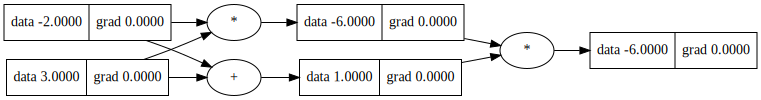

In [5]:
draw_dot(d)

In [6]:
class Neuron:
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))

    def __call__(self,x):
        # w*x+b
        act=sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out=act.tanh()
        return out

    def parameters(self):
        return self.w+[self.b]


class Layer:

    #nin=number of input to each neuron, nout=number of neuron in each layer
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs=[neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]


class MLP:
    #nin=number of layer in MLP, nouts=list consisting of number of neuron in each layer
    def __init__(self,nin,nouts):
        sz=[nin]+nouts
        self.layers=[Layer(sz[i],sz[i+1])for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]






In [7]:
x=[-1.0,2.0,3.2,5.1]
n=MLP(4,[4,8,8,4,1])
n(x)


Value(data=0.6489545759233757)

In [8]:
xs=[
    [2.2,4.0,-5.0,0.2],
    [0.4,-0.8,2.0,1.2],
    [-0.9,0.5,3.0,1.0],
]
ys=[1.0,0.25,-0.7] #desired targets


In [9]:
# ypred=[n(x) for x in xs]
# loss=sum((yout-ygt)**2 for yout,ygt in zip(ypred,ys))
# ypred


In [10]:
# loss.backward()
# loss

In [11]:
# for p in n.parameters():
#     p.data+= -0.01 * p.grad


In [12]:
losses=[]
for _ in range(1000):
    ypred=[n(x) for x in xs] #forward pass
    loss=sum((yout-ygt)**2 for yout,ygt in zip(ypred,ys))
    losses.append(loss.data)

    for k in n.parameters():
        k.grad=0
    loss.backward()
    for p in n.parameters():
        p.data+= -0.01 * p.grad



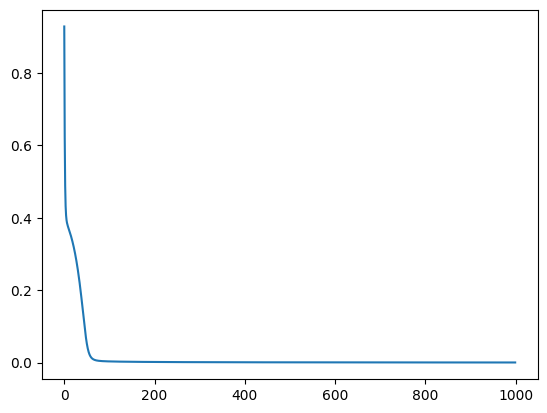

In [13]:
plt.plot(losses)
plt.show()

In [14]:
ypred

[Value(data=0.979148892592266),
 Value(data=0.24983969540824963),
 Value(data=-0.699900857425786)]